# 分析screen数据

采用chronos流程分析screen数据，并与我们现有的mageck RRA/MLE 分析结果作比较

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import chronos
import os
from matplotlib import pyplot as plt
import seaborn as sns
#from taigapy import default_tc as tc

C:\Users\fan_qiangqiang\AppData\Local\Temp\ipykernel_24416\2037430326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Some tweaks that will make plots more legible

In [3]:
from matplotlib import rcParams
rcParams['axes.titlesize'] = 14
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['savefig.dpi'] = 200
rcParams['savefig.transparent'] = False
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = '11'
rcParams['figure.dpi'] = 200
rcParams["savefig.facecolor"] = (1, 1, 1.0, 0.2)

rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 7

## Setting up the Data

Chronos always requires at least three dataframes: 
* a matrix of readcounts with sequenced entities as the index, individual sgRNAs as the columns, and values indicating how many reads were found for that sgRNA. A sequenced entity any vector of sgRNA readcounts read out during the experiment. It could be a sequencing run of pDNA, or of a biological replicate at some time point during the experiment.
* A sequence map mapping sequenced entities to either pDNA or a cell line and giving the days since infection and pDNA batch. 
* A guide map mapping sgRNAs to genes. Each sgRNA included must map to one and only one gene.

Below, we'll load a small subset of the DepMap Avana data. The files have been reformatted from the release to the format Chronos expects

In [59]:
#读入我们自己的数据：
sequence_map=pd.read_excel("QC_crispr/example_data/sequence_map.xlsx")
sequence_map[:5]

,sequence_ID,cell_line_name,pDNA_batch,days
0,A375-Base-NTC-1,pDNA,0,0
1,A375-Base-NTC-2,pDNA,0,0
2,A375-Base-NTC-3,pDNA,0,0
3,A375-Base-KAT7-1,pDNA,1,0
4,A375-Base-KAT7-2,pDNA,1,0


Sequence maps must have the columns

* sequence_id (str), which must match a row in readcounts
* cell_line_name (str). Must be "pDNA" for pDNA, and each pDNA batch must have at least one pDNA measurement.
* pDNA batch (any simple hashable type, preferably int or str). pDNA measurements sharing the same batch will be grouped and averaged, then used as the reference for all biological replicate sequencings assigned that same batch. If you don't have multiple pDNA batches (by far the most common experimental condition), just fill this column with 0 or some other constant value.
* days: days post infection. This value will be ignored for pDNA.

Other columns will be ignored.

Guide maps must have the columns 

* sgrna (str): must match a column in readcounts. An sgrna can only appear once in this data frame.
* gene (str): the gene the sgrna maps to.

Other columns will be ignored.

In [17]:
#读入我们自己的数据：
guide_map=pd.read_csv("QC_crispr/example_data/human.TKOv3_guide_sequence_Addgene90294.csv").rename(columns={'id': 'sgrna', 'Gene': 'gene'})
guide_map=guide_map[['sgrna','gene']]
guide_map[:4]

,sgrna,gene
0,sg_A1BG_1,A1BG
1,sg_A1BG_2,A1BG
2,sg_A1BG_3,A1BG
3,sg_A1BG_4,A1BG


Finally, here's what readcounts should look like. They can include NaNs. Note the axes.

In [34]:
#读入我们自己的数据：
readcounts=pd.read_csv("QC_crispr/example_data/all.count.txt",sep="\t",index_col='sgRNA').drop('Gene', axis=1)
#guide_map=guide_map[['sgrna','gene']]
readcounts=readcounts.T
readcounts.iloc[:4, :3]

sgRNA,sg_SLC36A2_3,sg_PIWIL3_3,sg_FBXO21_2
A375-Base-NTC-1,2107,691,2867
A375-Base-NTC-2,2075,675,2670
A375-Base-NTC-3,2019,593,2681
A375-Base-KAT7-1,2158,611,2662


In [70]:
readcounts.to_csv("readcounts.csv")

To QC the data, we'll want control groups. We'll use predefined sets of common and nonessential genes, and use these to define control sets of sgRNAs.

In [37]:
common_essentials = pd.read_csv("D:/AllDatabase/depmap/Chronos/chronos/Data/SampleData/AchillesCommonEssentialControls.csv")["Gene"]
nonessentials = pd.read_csv("D:/AllDatabase/depmap/Chronos/chronos/Data/SampleData/AchillesNonessentialControls.csv")["Gene"]

In [43]:
common_essentials = pd.read_csv("QC_crispr/example_data/essentail_nonessential/AchillesCommonEssentialControls.csv")["Gene"]
nonessentials = pd.read_csv("QC_crispr/example_data/essentail_nonessential/AchillesNonessentialControls.csv")["Gene"]

positive_controls = guide_map.sgrna[guide_map.gene.isin(common_essentials)]
negative_controls = guide_map.sgrna[guide_map.gene.isin(nonessentials)]

以上数据全部准备妥当后，开始进行后续 gene effect分析！

In [73]:
tmp=pd.read_csv("./Project_02/data/readcounts.csv",index_col=0)

In [74]:
tmp.iloc[:4, :3]

,sg_SLC36A2_3,sg_PIWIL3_3,sg_FBXO21_2
A375-Base-NTC-1,2107,691,2867
A375-Base-NTC-2,2075,675,2670
A375-Base-NTC-3,2019,593,2681
A375-Base-KAT7-1,2158,611,2662


### NaNing clonal outgrowths

In Achilles, we've observed rare instances where a single guide in a single biological replicate will produce an unexpectedly large number of readcounts, while other guides targeting the same gene or other replicates of the same cell line do not show many readcounts. We suspect this is the result of a single clone gaining some fitness advantage. Although it _could_ be related to a change induced by the guide, in general it's probably misleading. Therefore Chronos has an option to identify and remove these events.

In [60]:
chronos.nan_outgrowths(readcounts=readcounts, guide_gene_map=guide_map,
                                   sequence_map=sequence_map)

calculating LFC
finding maximum LFC calls
filtering
finding second highest LFC calls
finding sequences and guides with outgrowth


D:\Miniconda3\envs\chronos\Lib\site-packages\chronos\model.py:418: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  max_lfc = lfc.groupby(ggtemp, axis=1).max()
D:\Miniconda3\envs\chronos\Lib\site-packages\chronos\model.py:433: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  max_row_2nd_column = lfc_filtered.T.groupby(ggtemp, axis=0).agg(second_highest).T
D:\Miniconda3\envs\chronos\Lib\site-packages\chronos\model.py:444: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  masked = masked.reindex(index=lfc_filtered.index, columns=ggtemp.values).fillna(False)
D:\Miniconda3\envs\chronos\Lib\site-packages\chronos\model.py:449: FutureWarning: Downcasting obje

NAing 3 readcounts (0.00000 of total)


### QCing the data

You can generate a report with basic QC metrics about your data. You don't have to have control guides to do this, but the report is most useful if you do. If you don't have the `reportlab` python package installed, this section will error and should be skipped. This command will write a pdf report named "Initial QC.pdf" in the `./Data/reports` directory.

In [61]:
reportdir = "./Project_02/reports"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Project_02/reports"
! mkdir "./Project_02/reports"

'rm' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
子目录或文件 ./Project_02/reports 已经存在。


In [ ]:
from chronos import reports
metrics = reports.qc_initial_data("Initial QC", readcounts, sequence_map,guide_map, 
        negative_controls, positive_controls,
                  directory=reportdir
       )

Look in the Data/reports directory to see the QC report, "Initial QC.pdf".

## Train Chronos

### Creating the model

Now we initialize the model. Note the form of the data: each of the three parameters is actually a dictionary. If we were training the model with data from multiple libraries simultaneously, each library's data would have its own entries in the dict. 

The `negative_control_sgrnas` is an optional parameter, but including it will allow 1. better removal of library size effects from readcounts, and 2. estimation of the negative binomial quadratic overdispersion parameter per screen, which is otherwise a fixed hyperparameter. If provided, these should be cutting sgRNAs that are strongly expected to have no viability impact.

`log_dir` is an optional argument containing a directory for tensorflow to write summaries to. We include it here so that tensorboard can load the model.

In [63]:
logdir = "./Project_02/logs"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Project_02/logs"
! mkdir "./Project_02/logs"

'rm' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
子目录或文件 ./Project_02/logs 已经存在。


In [64]:
model = chronos.Chronos(
    sequence_map={"screen": sequence_map},
    guide_gene_map={"screen": guide_map},
    readcounts={"screen": readcounts},
    negative_control_sgrnas={"screen": negative_controls},
    log_dir=logdir
)

normalizing readcounts


Finding all unique guides and genes
found 71090 unique guides and 18195 unique genes in screen
found 71090 unique guides and 18195 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 12 unique sequences (excluding pDNA) and 4 unique cell lines in screen
found 12 unique replicates and 4 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for screen
Between 3 (batch=Index(['screen_0'], dtype='object')) and 4 (batch=Index(['screen_1'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
Creating excess variance tensors
	Created excess variance tensor for screen with shape [12, 1]
initializing graph

building gene effect mask

building doubling vectors
m

D:\Miniconda3\envs\chronos\Lib\site-packages\chronos\model.py:1200: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\


	built normalized timepoints for screen with shape (12, 71090) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (2, 71090) for screen
building guide efficacy
built guide efficacy: shape [1, 71091]
building growth rate
built growth rate: shape {'screen': [4, 1]}

building cell line efficacy
built cell line efficacy: shapes {'screen': [4, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 4 cell lines by 18195 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'screen': [12, 18195]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'screen': [4, 18195]}

building combined efficacy
built combined efficacy, shape {'screen': [4, 71090]}
built expanded combined efficacy, shapes {'screen': [12, 71090]}

building growth estimates of edited cells and overall estimates of fold change in guide abundance
built grow

D:\Miniconda3\envs\chronos\Lib\site-packages\chronos\model.py:1776: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	screen _gene_effect
	screen _selected_efficacies
	screen_predicted_readcounts_unscaled
	screen _predicted_readcounts
	screen _normalized_readcounts
	screen _cost_presum
sess run
	screen _cost
	screen _full_costs
ready to train


If you have tensorboard, the cell below will show Chronos' node structure. `GE` means gene effect (relative change in growth rate), `FC` means predicted fold change, `t0` is the inferred relative guide abundance at t0, and `out_norm` is the predicted readcounts. 

### Train

Below, we train  the model for 301 epochs. This should take a minute or so with periodic updates provided

In [65]:
model.train(301, report_freq=50, burn_in_period=50, ge_only=0)

NB2 cost 0.35722265600351927
Full cost 0.3773184136739302
relative_growth_rate
	screen max 1.013, min 0.98135
mean guide efficacy 0.9921000511287051
t0_offset SD: [('screen', 6.598721251686282e-05)]

gene mean -0.10811382861761017
SD of gene means 0.3656342792340033
Mean of gene SDs 0.10002535882936524



51 epochs trained, time taken 0:01:09, projected remaining 0:05:40
NB2 cost 0.21808182653369848
Full cost 0.24438507310879265
relative_growth_rate
	screen max 1.309, min 0.68164
mean guide efficacy 0.9289375897796961
t0_offset SD: [('screen', 0.1473284000527602)]

gene mean 0.02575289524317006
SD of gene means 0.45487560734556265
Mean of gene SDs 0.08261509699984836



101 epochs trained, time taken 0:02:02, projected remaining 0:04:01
NB2 cost 0.1850606645924948
Full cost 0.22279747403733857
relative_growth_rate
	screen max 1.367, min 0.64711
mean guide efficacy 0.85235846190629
t0_offset SD: [('screen', 0.18584178434782142)]

gene mean 0.012018554963372858
SD of gene means 0.4846495

## After Training

### Saving and Restoring

Chronos' `save` method dumps all the inputs, outputs, and model parameters to the specified directory. These files are written such that they can be read in individually and analyzed, but also used to restore the model by passing the directory path to the function `load_saved_model`.

In [66]:
savedir = "Project_02/Achilles_run"

In [54]:
if not os.path.isdir(savedir):
    os.mkdir(savedir)

In [67]:
model.save(savedir, overwrite=True)

In [56]:
print("Saved files:\n\n" + '\n'.join(['\t' + s for s in os.listdir(savedir)
                if s.endswith("csv")
                or s.endswith("hdf5")
                or s.endswith("json")
                ]))

Saved files:

	avana_guide_gene_map.csv
	avana_negative_control_sgrnas.csv
	avana_predicted_lfc.hdf5
	avana_predicted_readcounts.hdf5
	avana_readcounts.hdf5
	avana_sequence_map.csv
	cell_line_efficacy.csv
	cell_line_growth_rate.csv
	gene_effect.hdf5
	guide_efficacy.csv
	library_effect.csv
	parameters.json
	screen_delay.csv
	screen_excess_variance.csv
	t0_offset.csv


The .hdf5 files are binaries written with chronos' `write_hdf5` function, which is an efficient method for writing large matrices. They can be read with chronos' `read_hdf5` function.

Restoring the model can be done with a single function call:

In [22]:
model_restored = chronos.load_saved_model(savedir)



Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 3474 unique guides and 883 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA) and 44 unique cell lines in avana
found 92 unique replicates and 44 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Between 0 (batch=Index(['avana_avana_Avana-2', 'avana_avana_Avana-3', 'avana_avana_Avana-4'], dtype='object')) and 0 (batch=Index(['avana_avana_Avana-2', 'avana_avana_Avana-3', 'avana_avana_Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented in the screens and excluded.
Creating excess variance tensors
	Created excess variance tensor for avana with shape

D:\AllDatabase\depmap\Chronos\chronos\chronos\model.py:1200: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\


made t0 batch with shape (3, 3474) for avana
building guide efficacy
built guide efficacy: shape [1, 3475]
building growth rate
built growth rate: shape {'avana': [44, 1]}

building cell line efficacy
built cell line efficacy: shapes {'avana': [44, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 44 cell lines by 883 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 883]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'avana': [44, 883]}

building combined efficacy
built combined efficacy, shape {'avana': [44, 3474]}
built expanded combined efficacy, shapes {'avana': [92, 3474]}

building growth estimates of edited cells and overall estimates of fold change in guide abundance
built growth and change

building unnormalized estimates of final abundance
built unnormalized abundance

building normalized estimates of final abundance
built normalized abu

In [23]:
print("trained model cost: %f\nrestored model cost: %f" % (model.cost, model_restored.cost))

trained model cost: 0.204888
restored model cost: 0.204888


The most important file for most use cases is gene_effect.hdf5, which holds Chronos' estimate of the relative change in growth rate caused by gene knockouts. Negative values indicate inhibitory effects. You can also access the gene effect (and other parameters) from the trained model directly:

In [68]:
gene_effects = model.gene_effect

gene_effects.iloc[:4, :5]

gene,A1BG,A1CF,A2M,A2ML1,A3GALT2
cell_line_name,,,,,
A375-D14-KAT7,-0.064130,0.112835,0.222264,0.298991,0.121528
A375-D14-NTC,-0.253452,0.170818,0.012329,0.255608,0.133031
A375-D21-KAT7,0.013797,0.073587,0.239886,0.285557,0.166216
A375-D21-NTC,-0.231048,0.198291,0.047607,0.290062,0.083131


In [69]:
gene_effects.to_csv(savedir+"/gene_effects.csv")

### Copy Number Correction

If you have gene-level copy number calls, Chronos includes an option to correct gene effect scores after the fact. This works best if the data has been scaled, as above.

In [25]:
cn = chronos.read_hdf5("Data/SampleData/OmicsCNGene.hdf5")
cn.iloc[:4, :3]

,A1CF (29974),A2M (2),A2ML1 (144568)
ACH-001636,1.110663,1.047670,1.047670
ACH-000784,1.193826,1.161938,1.109943
ACH-000147,1.365585,0.499068,0.499068
ACH-000657,1.033547,1.040547,1.040547


Unfortunately, we don't have copy number calls for one of the genes targeted by the Avana library:

In [28]:
gene_effects.shape

(44, 883)

In [29]:
cn.shape

(58, 898)

In [26]:
try:
    corrected, shifts = chronos.alternate_CN(gene_effects, cn)
except ValueError as e:
    print(e)

Missing 1 genes from gene_effect in copy_number.
Examples: ['POU2AF3 (120376)']


We could choose to drop these genes. Instead, we'll assume normal ploidy (=1, in the current CCLE convention) for them and fill in the CN matrix accordingly.

In [30]:
for col in set(gene_effects.columns) - set(cn.columns):
    cn[col] = 1

In [31]:
corrected, shifts = chronos.alternate_CN(gene_effects, cn)


Fitting cell line group 1 of 1
finding low CN gene effect shifts
smoothing and interpolating cutting toxicity for all genes
constructed spline matrix of shape 38852, 105
	cost: 0.03961228163435683
	cost: 0.038692256789989436
	cost: 0.038554140427258264
	cost: 0.03847019486896836
	cost: 0.038411667797341044
	cost: 0.03837062317816208
generating matrix


The `shifts` dataframe contains some information about the inferred CN effect, while `corrected` contains the corrected gene effects matrix. Overall, gene effect matrices will change little after correction, since most genes in most lines are near diploid.

We'll write the corrected dataframe to the saved directory we made earlier

In [32]:
chronos.write_hdf5(corrected, os.path.join(savedir, "gene_effect_corrected.hdf5"))

### QC report

The function `dataset_qc_report` in the `reports` module of Chronos presents a variety of QC metrics and interrogates some specific examples. The report minimally requires a set of positive and negative control genes. To get the full report requires copy number, mutation data, expression data, a list of expression addictions (genes which are dependencies in highly expressing lines), and oncogenic mutations.

Below, we'll load an annotated DepMap MAF file (subsetted to our cell lines). We'll select gain of function cancer driver events from it and generate a binary mutation matrix. We have a prior belief that cell lines with driver gain of function mutation events will be dependent on the mutated gene, so this matrix will be used by the QC report to assess our ability to identify selective dependencies. Specifically, we expect the oncogenes in this matrix to be dependencies in cell lines where the matrix is `True`, and not otherwise.

In [33]:
maf = pd.read_csv("Data/SampleData/OmicsSomaticMutations.csv")

In [34]:
cancer_relevant = maf[
  (
      maf.Driver | maf.LikelyDriver  
  ) & (
      maf.LikelyGoF
  )
]


cancer_relevant = cancer_relevant[~cancer_relevant.duplicated(subset=["ModelID", "Gene"])]

cancer_relevant['truecol'] = True

gof_matrix_base = pd.pivot(cancer_relevant, index="ModelID", columns="Gene", values="truecol")

Another way to evaluate selective dependencies is using expression addictions, a common pattern in which a gene is a stronger dependency in lines with higher expression. We'll use a list derived from DepMap RNAi (Tsherniak et al., Cell 2017), and subset our expression matrix to match.

In [35]:
expression_addictions = pd.read_csv("Data/SampleData/RNAiExpressionAddictions.csv")['Gene']

In [36]:
addiction_expressions = chronos.read_hdf5("Data/SampleData/OmicsExpressionProteinCodingGenesTPMLogp1.hdf5")[
    expression_addictions
]

Now, we're ready to run the QC report on Chronos' results:

Loading data from Data/Achilles_run
plotting global control separation
plotting selective dependency separation


D:\AllDatabase\depmap\Chronos\chronos\chronos\evaluations.py:125: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aligned_matrix = base_matrix.reindex(gene_effect.index).fillna(False)
D:\AllDatabase\depmap\Chronos\chronos\chronos\evaluations.py:761: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = [plt.text(s=neg_means.index[i],x=neg_means[i], y=pos_means[i], fontsize=6, color=[.8, .3, .05]) for i in outliers]


AttributeError: FancyArrowPatch.set() got an unexpected keyword argument 'expand_points'

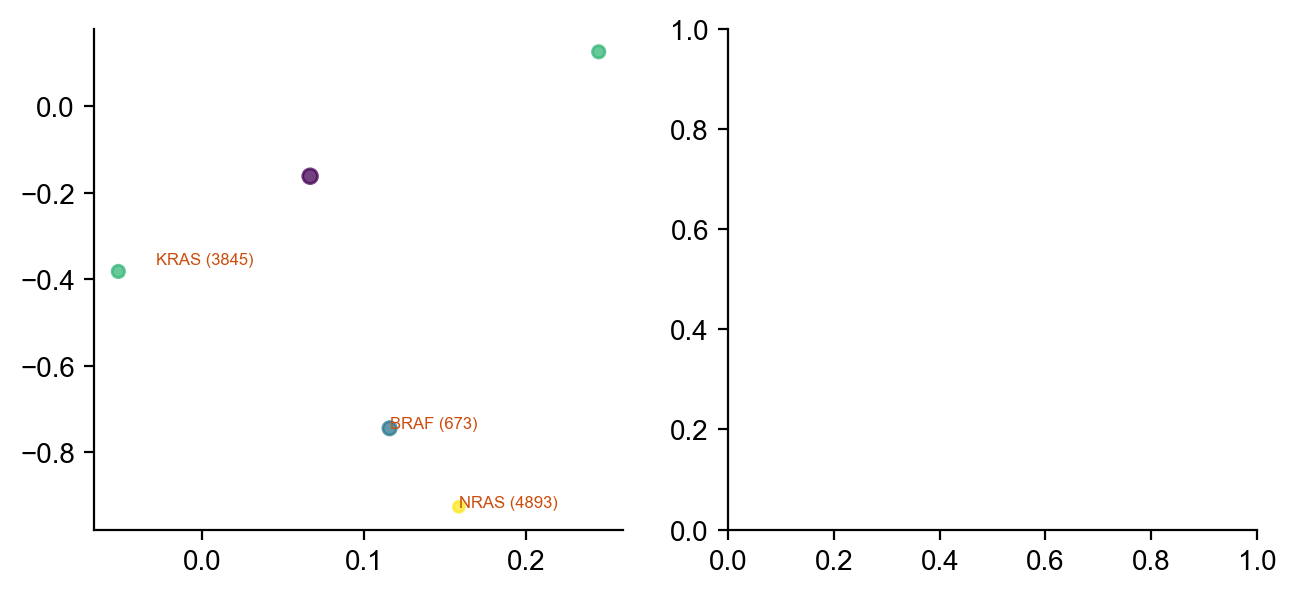

In [37]:
metrics = reports.dataset_qc_report("ChronosAvana", savedir, 
                          common_essentials, nonessentials,
                          gof_matrix_base, addiction_expressions,
                          cn, directory="Data/reports",
                          gene_effect_file="gene_effect_corrected.hdf5"
                         )

## Running with multiple libraries

We can add Sanger's [Project Score](https://www.nature.com/articles/s41586-019-1103-9) data (screened with the KY library) and run Chronos jointly on it and the Avana data. 

In [6]:
ky_guide_map = pd.read_csv("./Data/SampleData/KYGuideMap.csv")
ky_sequence_map = pd.read_csv("./Data/SampleData/KYSequenceMap.csv")
ky_readcounts = chronos.read_hdf5("./Data/SampleData/KYReadcounts.hdf5")

In [9]:
ky_positive_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(common_essentials)]
ky_negative_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(nonessentials)]

Note how the call signature of Chronos with multiple libraries is constructed:

In [10]:
model2 = chronos.Chronos(
    sequence_map={"avana": sequence_map, 'ky': ky_sequence_map},
    guide_gene_map={"avana": guide_map, 'ky': ky_guide_map},
    readcounts={"avana": readcounts, 'ky': ky_readcounts},
    negative_control_sgrnas={"avana": negative_controls, "ky": ky_negative_controls}
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 4084 unique guides and 833 unique genes in ky
found 7558 unique guides and 887 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA) and 44 unique cell lines in avana
found 63 unique sequences (excluding pDNA) and 23 unique cell lines in ky
found 155 unique replicates and 58 unique cell lines overall

finding replicate-cell line mappings indices

finding replicate-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Between 0 (batch=Index(['avana_Avana-2', 'avana_Avana-3', 'avana_Avana-4'], dtype='object')) and 0 (batch=Index(['avana_Avana-2', 'avana_Avana-3', 'avana_Avana-4'], dtype='object')) negative control sgRNAs were found to be systematically over- or under-represented 

D:\AllDatabase\depmap\Chronos\chronos\chronos\model.py:1200: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
D:\AllDatabase\depmap\Chronos\chronos\chronos\model.py:1203: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
D:\AllDatabase\depmap\Chronos\chronos\chronos\model.py:1200: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map[key].set_index("sgrna").gene, axis=1)\
D:\AllDatabase\depmap\Chronos\chronos\chronos\model.py:1203: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call


building doubling vectors
made days vector of shape [92, 1] for avana
made days vector of shape [63, 1] for ky

building late observed timepoints
	built normalized timepoints for avana with shape (92, 3474) (replicates X guides)
	built normalized timepoints for ky with shape (63, 4084) (replicates X guides)

building t0 reads


Building variables

building t0 reads estimate
made t0 batch with shape (2, 4084) for avana
made t0 batch with shape (2, 4084) for ky
building guide efficacy

built guide efficacy: shape [1, 7559]
building growth rate
built growth rate: shape {'avana': [58, 1], 'ky': [58, 1]}

building cell line efficacy
built cell line efficacy: shapes {'avana': [58, 1], 'ky': [58, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 58 cell lines by 887 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 887], 'ky': [63, 887]}

building gene effect growth graph nodes
built gene effec

D:\AllDatabase\depmap\Chronos\chronos\chronos\model.py:1776: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\
D:\AllDatabase\depmap\Chronos\chronos\chronos\model.py:1776: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(guide_gene_map.set_index("sgrna").gene, axis=1)\


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
sess run
	avana _cost
	avana _full_costs
	ky _gene_effect
	ky _selected_efficacies
	ky_predicted_readcounts_unscaled
	ky _predicted_readcounts
	ky _normalized_readcounts
	ky _cost_presum
sess run
	ky _cost
	ky _full_costs
ready to train


In [11]:
model2.train(301)

NB2 cost 0.35361475680124105
Full cost 0.4917222763249988
relative_growth_rate
	avana max 1.045, min 0.96485
	ky max 1.044, min 0.94774
mean guide efficacy 0.9920655031759262
t0_offset SD: [('avana', 7.050627588270117e-05), ('ky', 7.570223192341395e-05)]

gene mean -0.27339406178671705
SD of gene means 0.43117127653205517
Mean of gene SDs 0.3529388517167343



51 epochs trained, time taken 0:00:09, projected remaining 0:00:43
NB2 cost 0.24866558560300853
Full cost 0.3090075963113838
relative_growth_rate
	avana max 1.360, min 0.57175
	ky max 1.446, min 0.51292
mean guide efficacy 0.9332794359966298
t0_offset SD: [('avana', 0.13892146932613245), ('ky', 0.13854381943117977)]

gene mean -0.09891669858266534
SD of gene means 0.5526316103308444
Mean of gene SDs 0.2780052597930531



101 epochs trained, time taken 0:00:17, projected remaining 0:00:33
NB2 cost 0.23195734011555186
Full cost 0.25549300354321536
relative_growth_rate
	avana max 1.541, min 0.43887
	ky max 1.259, min 0.67917
mean gu

Note that the gene effect now has NAs. These are cases where a cell line was only screened in one library and that library had no guides for that gene.

Chronos infers library batch effects. Note that these are only inferred for genes present in all libraries

In [12]:
model2.library_effect

library,avana,ky
gene,,
A1CF (29974),-0.131074,0.105497
A2M (2),-0.275337,0.221607
A2ML1 (144568),-0.219256,0.176470
A3GALT2 (127550),-0.053114,0.042749
A4GALT (53947),-0.128074,0.103081
...,...,...
ZNF622 (90441),-0.197585,0.159029
ZNF648 (127665),-0.152026,0.122359
ZNF804B (219578),-0.223024,0.179503


In [14]:
gene_effects=model2.gene_effect
gene_effects.head()

gene,A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),AADACL2 (344752),...,ZFP36L1 (677),ZG16 (653808),ZMAT2 (153527),ZNF207 (7756),ZNF48 (197407),ZNF622 (90441),ZNF648 (127665),ZNF804B (219578),ZP2 (7783),ZSWIM2 (151112)
cell_line_name,,,,,,,,,,,,,,,,,,,,,
ACH-000004,0.394265,0.270410,0.382605,0.335398,0.248460,0.675958,0.275590,0.618237,0.620192,0.372236,...,0.338218,0.440582,-1.408095,-0.935909,0.387483,0.192241,0.220976,0.424845,0.489797,0.629683
ACH-000074,0.380960,0.648621,0.756778,0.300992,0.343178,0.616668,0.662109,0.563376,0.614896,0.493008,...,0.215490,0.734086,-1.082159,-0.523650,0.502956,0.214192,0.433352,0.380885,0.424405,1.210500
ACH-000147,0.409097,0.489411,0.545690,0.093653,0.429734,0.520911,0.113429,0.448858,0.587061,0.359995,...,0.343936,0.470957,-1.108628,-0.718659,0.406244,0.366363,0.343674,0.468244,0.495879,0.524347
ACH-000149,0.653138,0.505769,0.384833,0.224746,0.401323,0.471192,0.262684,0.443614,0.743491,0.357139,...,0.291560,0.490942,-0.971483,-0.590033,0.146912,-0.099377,0.123623,0.336375,0.336885,0.535194
ACH-000168,0.396901,0.553080,0.651399,0.301351,0.370373,0.256483,0.144081,0.301891,0.330681,0.517162,...,0.291742,0.217815,-0.891559,-0.568605,0.483745,-0.056047,0.295632,0.291499,0.497072,0.693636


In [15]:
gene_effects.shape

(58, 887)

## Running your screen with pretrained DepMap parameters

If you conducted a screen in one of the DepMap integrated libraries (currently Avana, KY, or Humagne-CD), you can load parameters from the trained DepMap model and use them to process your specific screen. This gives you many of the benefits of coprocessing your screen with the complete DepMap dataset without the computational expense. 

The following command fetches the 22Q3 public dataset from Figshare and stores it in the Chronos package directory under Data/DepMapParameters

In [ ]:
chronos.fetch_parameters()

First, we create a model with the data we want to train as before, but with two important details:
- we pass the argument `pretrained=True` when we initialize
- the library batch names must match the DepMap library batch names, as that's what we're using for the pretrained model

In [ ]:
model2_pretrained = chronos.Chronos(
    sequence_map={"Achilles-Avana-2D": sequence_map, 'Achilles-KY-2D': ky_sequence_map},
    guide_gene_map={"Achilles-Avana-2D": guide_map, 'Achilles-KY-2D': ky_guide_map},
    readcounts={"Achilles-Avana-2D": readcounts, 'Achilles-KY-2D': ky_readcounts},
    negative_control_sgrnas={"Achilles-Avana-2D": negative_controls, "Achilles-KY-2D": ky_negative_controls},
    pretrained=True
)

Now we import the DepMap data from the directory into the model, and train:

In [ ]:
model2_pretrained.import_model("./Data/DepMapParameters/")

In [ ]:
model2_pretrained.train()

## python通过yaml文件获取配置信息

In [20]:
import yaml
# 打开YAML文件
with open('data.yaml', 'r') as file:
    # 加载YAML内容到字典对象
    data = yaml.safe_load(file)
    
print(data)

{'sequence_map': 'Data/SampleData/AvanaSequenceMap.csv', 'guide_map': 'Data/SampleData/AvanaGuideMap.csv', 'readcounts': 'Data/SampleData/AvanaReadcounts.hdf5', 'common_essentials': 'Data/SampleData/AchillesCommonEssentialControls.csv', 'nonessentials': 'Data/SampleData/AchillesNonessentialControls.csv'}


In [21]:
data['sequence_map']

'Data/SampleData/AvanaSequenceMap.csv'

In [24]:
import os
os.makedirs('./test/QC')

## 总结

1. 输入3个文件：sequence_map, guide_map, read_counts，
2. 2个essential文件：common_essential, nonessential
3. 建模，training，分析和保存结果
4. 对结果进一步可视化分析

```
#会在当前目录下找data.yaml，提前配置好 data.yaml 文件
python chronos_v1.py
```

## 与Mageck结果比较

主要参考： `chronos_vs_mageck.R`


mageck 分析特别简单，先使用conda安装mageck，然后使用MLE, RRA进行分组分析;

#https://sourceforge.net/p/mageck/wiki/advanced_tutorial/

+ mle

```
mageck mle -k GSE126486_sgRNA.txt -d design_matrix -n test

#design matrix: 行是样本名，列是分组
```

+ RRA

```
mageck test -k sample.txt -t HL60.final,KBM7.final -c HL60.initial,KBM7.initial  -n demo
```

In [ ]:
#比较mageck rra  和 chronos的分析结果
#mageck rra的分析结果在这里，一共四组：
#D:\CRISPR\QC_crispr\example_data\RRA

#chronos的分析结果在这里，也是四组：
#D:\CRISPR\Project_02\Achilles_run

library(data.table)
library(dplyr)
library(ggplot2)

### Chronos分析结果

#### gene effect 分布密度图

In [ ]:
chronos_gene_effect<-fread("Project_02/Achilles_run/gene_effects.csv")
#wide2long
p1=chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  ggplot(aes(Effect,colour=cell_line_name))+
  stat_density(geom='line',position = 'identity')+
  labs(title="Chronos")+
  theme_bw(
    base_size = 15
  )+
  theme(
    legend.position =  c(0.2,0.8),
    legend.background = element_blank()
  )

#### 不同类型基因 effect 分布

+ essential_gene
+ non_targeting
+ nonessential_gene
+ others

In [ ]:
geneTypes=readxl::read_xlsx("QC_crispr/example_data/4_types_of_genes.xlsx") %>% setnames(c("Gene","geneType"))
p3=chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  inner_join(.,geneTypes) %>% 
  ggplot(aes(Effect,colour=geneType))+
  stat_density(geom='line',position = 'identity')+
  facet_wrap(~cell_line_name)+
  labs(title="Chronos")+
  theme_bw(
    base_size = 15
  )

#### 不同类型基因 effect boxplot可视化

In [ ]:
p5=chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  inner_join(.,geneTypes) %>% 
  ggplot(aes(x=geneType,y=Effect,fill=cell_line_name))+
  geom_boxplot()+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 30,vjust = 1,hjust = 1)
  )
  

#### 计算SSMD 和 NNMD

+ SSMD：strictly standardized mean difference
+ NNMD: null-normalized median difference

In [ ]:
ssmd2=chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  inner_join(.,geneTypes) %>%
  group_by(cell_line_name,geneType) %>% 
  summarise(
    u=mean(Effect),
    sd=sd(Effect)
  ) %>% 
  filter(grepl("Gene",geneType)) %>% 
  tidyr::pivot_wider(names_from = geneType, values_from = c(u,sd)) %>% 
  mutate(SSMD=(u_Essential_Gene-u_Nonessential_Gene)/sqrt(sd_Essential_Gene+sd_Nonessential_Gene)) %>% 
  mutate(Groups=c("Chronos")) %>% 
  select(c('cell_line_name','SSMD','Groups'))

NNMD2=chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  inner_join(.,geneTypes) %>%
  group_by(cell_line_name,geneType) %>% 
  summarise(
    u=mean(Effect),
    mad=mad(Effect)
  ) %>% 
  filter(grepl("Gene",geneType)) %>% 
  tidyr::pivot_wider(names_from = geneType, values_from = c(u,mad)) %>% 
  mutate(NNMD=(u_Essential_Gene-u_Nonessential_Gene)/mad_Nonessential_Gene) %>% 
  mutate(Groups=c("Chronos")) %>% 
  select(c('cell_line_name','NNMD','Groups'))

+ 结果可视化

In [ ]:
p7=rbind(ssmd1,ssmd2) %>% as.data.frame() %>% ggplot(aes(x=cell_line_name,y=SSMD,fill=Groups))+
  geom_bar(stat = 'identity', position='dodge') +
  scale_fill_manual(values=c("Chronos"="#1874CD","Mageck"="#7EC0EE"))+
  labs(title="SSMD")+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 30,vjust = 1,hjust = 1)
  )


p8=rbind(NNMD1,NNMD2) %>% as.data.frame() %>% ggplot(aes(x=cell_line_name,y=NNMD,fill=Groups))+
  geom_bar(stat = 'identity', position='dodge') +
  scale_fill_manual(values=c("Chronos"="#1874CD","Mageck"="#7EC0EE"))+
  labs(title="NNMD")+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 30,vjust = 1,hjust = 1)
  )


#### 相关性分析

Chronos的gene effect 结果与 mageck RRA 的 logfc 相关性比较

In [ ]:
#log2fc vs gene_effect 相关性系数
tmp=chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  mutate(id=paste0(cell_line_name,"_",Gene))
p9=tmps_df %>% mutate(id=paste0(groups,"_",gene)) %>% 
  inner_join(.,tmp) %>% 
  ggplot(aes(x=logfc,y=Effect))+
  geom_point(aes(colour=geneType))+
  facet_wrap(~groups)+
  labs(title="Correlation")+
  theme_bw(
    base_size = 15
  )


#### Rank gene effect

根据 gene effect 值，进行从小到大的排序可视化

目的： 寻找特定条件下的 dependency genes，用于靶点发现

In [ ]:
geneTypes=readxl::read_xlsx("QC_crispr/example_data/4_types_of_genes.xlsx") %>% setnames(c("Gene","geneType"))

+ 全基因 gene effect 排序可视化
+ 非 essential 基因的 gene effect 排序可视化

In [ ]:
tmp=chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  inner_join(.,geneTypes) %>% 
  mutate(geneType=as.factor(geneType))
tmp %>% group_by(cell_line_name) %>%
  arrange(desc(Effect)) %>% 
  mutate(rank_ID=1:n()) %>% 
  slice_min(.,Effect,n=5) -> top5_essential_genes
p10_A=tmp %>% group_by(cell_line_name) %>% 
  arrange(desc(Effect)) %>% 
  mutate(rank_ID=1:n()) %>% 
  ggplot(aes(x=rank_ID,y=Effect))+
  geom_point(aes(colour=geneType))+
  geom_text_repel(aes(x=rank_ID,y= Effect,label=Gene),data=top5_essential_genes)+
  facet_wrap(~cell_line_name)+  
  labs(title="Rank Effect")+
  theme_bw(
    base_size = 15
  )+
  theme(
    legend.position = 'bottom'
  )+
  guides(colour = guide_legend(nrow = 2))

tmp %>% group_by(cell_line_name) %>%
  filter(geneType!="Essential_Gene") %>% 
  arrange(desc(Effect)) %>% 
  mutate(rank_ID=1:n()) %>% 
  slice_min(.,Effect,n=5) -> top5_essential_genes
p10_B=tmp %>% group_by(cell_line_name) %>%  
  filter(geneType!="Essential_Gene") %>% 
  arrange(desc(Effect)) %>% 
  mutate(rank_ID=1:n()) %>% 
  ggplot(aes(x=rank_ID,y=Effect))+
  geom_point(aes(colour=geneType))+
  geom_text_repel(aes(x=rank_ID,y= Effect,label=Gene),data=top5_essential_genes)+
  facet_wrap(~cell_line_name)+  
  labs(title="Rank Effect")+
  theme_bw(
    base_size = 15
  )+
  theme(
    legend.position = 'bottom'
  )+
  guides(colour = guide_legend(nrow = 2))

#### 交叉比较分析

主要目的，是为了在多组条件下，筛选潜在的dependency genes

1. 同一化合物，不同时间点，gene effect 比较分析
2. 同一时间点，不同化合物，gene effect 比较分析

参考 `regression_linear.R`

In [ ]:
#计算回归曲线的，以及回归曲线中散点图的分布
chronos_gene_effect<-fread("Project_02/Achilles_run/gene_effects.csv")
geneTypes=readxl::read_xlsx("QC_crispr/example_data/4_types_of_genes.xlsx") %>% setnames(c("Gene","geneType"))


In [ ]:
#同一化合物，不同时间点比较
chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  inner_join(.,geneTypes) %>% filter(geneType!="Essential_Gene") %>% 
  mutate(Days=gsub(".*(D[0-9]{2})\\-.*","\\1",cell_line_name)) %>% 
  mutate(Compound=gsub(".*\\-(\\w*)","\\1",cell_line_name)) %>%
  select(c(Days,Gene,Effect,Compound)) %>% 
  tidyr::pivot_wider(names_from = Days, values_from = c(Effect)) %>% 
  setnames(c("Gene","Compound","y","x")) -> regression_data
#计算回归方程的系数
alphas=seq(0.1,10,by=0.1)
absolute_erros = lapply(
  alphas,
  FUN = function(alpha) {
    sum_absolute_error = regression_data %>%
      #计算垂直距离
      mutate(y_dist = abs(y - x * alpha)*(1/sqrt(1+alpha^2))) %>%
      select(y_dist) %>% sum()
  }
)
candidate_alpha=alphas[which.min(absolute_erros)]

#结果可视化，采用6倍SD，可以根据项目改动
sigma_sd = regression_data %>% mutate(y_dist = (y - x * candidate_alpha)*(1/sqrt(1+candidate_alpha^2)) ) %>% pull(y_dist) %>% sd()*6
library(ggrepel)
p1=regression_data %>% 
  ggplot(aes(x=x,y=y))+
  geom_point()+
  geom_point(aes(x=x,y=y),colour='grey',
             data=regression_data %>% 
               mutate(y_dist = (y - x * candidate_alpha)*(1/sqrt(1+candidate_alpha^2)) )%>% 
               filter(abs(y_dist) < sigma_sd)
             )+
  geom_text_repel(aes(x=x,y=y,label=Gene),
                  data=regression_data %>% 
                    mutate(y_dist = (y - x * candidate_alpha)*(1/sqrt(1+candidate_alpha^2)) )%>% 
                    filter(abs(y_dist) > sigma_sd)
                  )+
  geom_abline(slope = candidate_alpha,
              intercept = 0,colour='red',lwd=1.2)+
  #计算上部截距
  geom_abline(slope = candidate_alpha,
              intercept = c(sigma_sd/(1/sqrt(1+candidate_alpha^2))),
              colour='grey',lty=2,lwd=1.2)+
  #计算下部截距
  geom_abline(slope = candidate_alpha,
              intercept = c(- sigma_sd/(1/sqrt(1+candidate_alpha^2))),
              colour='grey',lty=2,lwd=1.2)+
  facet_wrap(~Compound)+
  labs(x="D21",y="D14")+
  theme_bw(
    base_size = 15
  )

In [ ]:
#不同化合物，同一时间点比较
chronos_gene_effect %>% 
  tidyr::pivot_longer(c(2:ncol(.)),names_to = 'Gene',values_to = 'Effect') %>% 
  inner_join(.,geneTypes) %>% filter(geneType!="Essential_Gene") %>% 
  mutate(Days=gsub(".*(D[0-9]{2})\\-.*","\\1",cell_line_name)) %>% 
  mutate(Compound=gsub(".*\\-(\\w*)","\\1",cell_line_name)) %>%
  select(c(Days,Gene,Effect,Compound)) %>% 
  tidyr::pivot_wider(names_from = Compound, values_from = c(Effect))%>% 
  setnames(c("Days","Gene","y","x")) -> regression_data
#计算回归方程的系数
alphas=seq(0.1,10,by=0.1)
absolute_erros = lapply(
  alphas,
  FUN = function(alpha) {
    sum_absolute_error = regression_data %>%
      #计算垂直距离
      mutate(y_dist = abs(y - x * alpha)*(1/sqrt(1+alpha^2))) %>%
      select(y_dist) %>% sum()
  }
)
candidate_alpha=alphas[which.min(absolute_erros)]

#结果可视化，采用6倍SD，可以根据项目改动
sigma_sd = regression_data %>% mutate(y_dist = (y - x * candidate_alpha)*(1/sqrt(1+candidate_alpha^2)) ) %>% pull(y_dist) %>% sd()*6
library(ggrepel)
p2=regression_data %>% 
  ggplot(aes(x=x,y=y))+
  geom_point()+
  geom_point(aes(x=x,y=y),colour='grey',
             data=regression_data %>% 
               mutate(y_dist = (y - x * candidate_alpha)*(1/sqrt(1+candidate_alpha^2)) )%>% 
               filter(abs(y_dist) < sigma_sd)
  )+
  geom_text_repel(aes(x=x,y=y,label=Gene),
                  data=regression_data %>%
                    mutate(y_dist = (y - x * candidate_alpha)*(1/sqrt(1+candidate_alpha^2)) )%>%
                    filter(abs(y_dist) > sigma_sd)
  )+
  geom_abline(slope = candidate_alpha,
              intercept = 0,colour='red',lwd=1.2)+
  #计算上部截距
  geom_abline(slope = candidate_alpha,
              intercept = c(sigma_sd/(1/sqrt(1+candidate_alpha^2))),
              colour='grey',lty=2,lwd=1.2)+
  #计算下部截距
  geom_abline(slope = candidate_alpha,
              intercept = c(- sigma_sd/(1/sqrt(1+candidate_alpha^2))),
              colour='grey',lty=2,lwd=1.2)+
  facet_wrap(~Days)+
  labs(x="NTC",y="KAT7")+
  theme_bw(
    base_size = 15
  )

In [ ]:
ps=ggarrange(p1,p2,nrow = 1)
ggsave("fig6_cross_comparisions_withoutessenGenes.jpg",ps,width = 12,height = 4)

+ 结论：

  1. 同一药物处理的细胞，不同时间点gene effect比较；gene dependency有明显时间效应，尤其是在KAT7组，相对差异基因多于NTC组
  2. 同一时间点不同药物处理细胞后，gene effect比较；明显的时间依赖性，在D21 会筛选出较多的 genes, 其中SNRPE基因较为显著
 
具体比较分析结果在： D:\CRISPR\chronos_vs_mageck

### Mageck-RRA 分析结果

In [ ]:
#mageck rra的分析结果
#D:\CRISPR\QC_crispr\example_data\RRA\A375-D14-KAT7_vs_A375-Base-KAT7
tmps=lapply(
  list.files("QC_crispr/example_data/RRA/"),
  FUN = function(x){
    tmp=readxl::read_xlsx(paste0("QC_crispr/example_data/RRA/",x,"/",x,".RRA.gene_summary.xlsx")) %>%
      mutate(group=gsub("(.*)\\_vs\\_.*","\\1",x)) %>% 
      select(c(1,7,group,label)) %>% 
      setnames(c("gene",'logfc','groups','geneType'))
  }
)
tmps_df=rbindlist(tmps)

In [ ]:
p2=tmps_df %>% 
  ggplot(aes(logfc,colour=groups))+
  stat_density(geom='line',position = 'identity')+
  labs(title="Mageck RRA")+
  theme_bw(
    base_size = 15
  )+
  theme(
    legend.position =  c(0.2,0.8),
    legend.background = element_blank()
  )

p4=tmps_df %>% 
  ggplot(aes(logfc,colour=geneType))+
  stat_density(geom='line',position = 'identity')+
  facet_wrap(~groups)+
  labs(title="Mageck RRA")+
  theme_bw(
    base_size = 15
  )

p6=tmps_df %>% ggplot(aes(x=geneType,y=logfc,fill=groups))+
  geom_boxplot()+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 30,vjust = 1,hjust = 1)
  )

#计算SSMD
ssmd1=tmps_df %>% group_by(groups,geneType) %>% 
  summarise(
    u=mean(logfc),
    sd=sd(logfc)
  ) %>% 
  filter(grepl("Gene",geneType)) %>% 
  tidyr::pivot_wider(names_from = geneType, values_from = c(u,sd)) %>% 
  mutate(SSMD=(u_Essential_Gene-u_Nonessential_Gene)/sqrt(sd_Essential_Gene+sd_Nonessential_Gene)) %>% 
  select(c(1,6)) %>% mutate(Groups=c("Mageck"))%>% setnames(c("cell_line_name","SSMD",'Groups')) 

NNMD1=tmps_df %>% group_by(groups,geneType) %>% 
  summarise(
    u=median(logfc),
    mad=mad(logfc)
  ) %>% 
  filter(grepl("Gene",geneType)) %>% 
  tidyr::pivot_wider(names_from = geneType, values_from = c(u,mad)) %>% 
  mutate(NNMD=(u_Essential_Gene-u_Nonessential_Gene)/mad_Nonessential_Gene) %>% 
  select(c(1,6)) %>% mutate(Groups=c("Mageck"))%>% setnames(c("cell_line_name","NNMD",'Groups')) 


## sgRNA QC 分析

使用mageck count，从fastq中解析出sgRNA coutns；基于样本 sgRNA counts 进行数据指控：

1. mapping rate
2. gini index
3. zero counts
4. counts distribution boxplot
5. counts distribution density
6. counts distribution cumulative distribution
7. positive / negative controls

分析结果在： D:\CRISPR\QC_crispr

In [ ]:
library(data.table)
library(dplyr)
library(ggplot2)
library(tidyr)


count_summary<-fread("QC_crispr/G1/group_G1.countsummary.txt")

### mapping rate

In [ ]:
p1=count_summary %>% 
  mutate(Unmapped=Reads-Mapped) %>% 
  select(c(Label,Unmapped,Mapped)) %>%
  tidyr::pivot_longer(c(Mapped,Unmapped),names_to = 'Group',values_to = 'Reads') %>%
  group_by(Label) %>% 
  mutate(Rate=round(Reads/sum(Reads),3)) %>% 
  ggplot(aes(x=Label,y=Reads))+
  geom_col(aes(fill=Group),position = position_stack(reverse = T),width = 0.8)+
  geom_text(aes(x=Label,y=Reads,label=ifelse(Group=="Mapped",Rate,'')),size=4) +
  labs(x="")+
  scale_fill_manual(values=c("Mapped"="#1874CD","Unmapped"="#7EC0EE"))+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
    legend.title=element_blank(),
    legend.position =  c(0.1,0.95),
    legend.background = element_blank()
  )
ggsave('fig1.png',p1,width = 10,height = 5)

### gini index

mageck 给出的结果，在0.25以上则表明sgRNA文库有明显的偏移

In [ ]:
p2=count_summary %>% 
  ggplot(aes(x=Label,y=GiniIndex))+
  geom_bar(stat = "identity",fill="#1874CD")+
  labs(x="")+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
  )
ggsave('fig2.png',p2,width = 10,height = 5)

### zero count

同样地，样本zero count也不能过多，否则会产生偏移，具体多少是多呢？

In [ ]:

p3=count_summary %>% 
  ggplot(aes(x=Label,y=Zerocounts))+
  geom_bar(stat = "identity",fill="#1874CD")+
  labs(x="")+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
  )
ggsave('fig3.png',p3,width = 10,height = 5)

### counts distribution Boxplot

In [ ]:

sgRNA_count=fread("QC_crispr/G1/group_G1.count.txt")
p4=sgRNA_count %>% select(-c(1,2)) %>% 
  tidyr::pivot_longer(everything(),names_to = 'Samples',values_to = 'Reads') %>% 
  ggplot(aes(x=Samples,y=log2(Reads+1)))+
  geom_boxplot(fill="#1874CD")+
  labs(x="",y="Log2 transformed sgRNA counts")+
  theme_bw(
    base_size = 15
  )+
  theme(
    axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
  )
ggsave('fig4.png',p4,width = 10,height = 5)

### counts distribution Density plot

In [ ]:

p5=sgRNA_count %>% select(-c(1,2)) %>% 
  tidyr::pivot_longer(everything(),names_to = 'Samples',values_to = 'Reads') %>% 
  ggplot(aes(Reads,colour=Samples))+
  stat_density(geom='line',position = 'identity')+
  labs(x="Reads Count",y='Frequency',title = 'Density plot of sgRNA reads')+
  theme_bw(
    base_size = 15
  )+
  theme(
    legend.title=element_blank(),
    legend.position =  c(0.8,0.5),
    legend.background = element_blank()
  )
ggsave('fig5.png',p5,width = 10,height = 5)


### counts distribution Cumulative plot

In [ ]:

p6=sgRNA_count %>% select(-c(1,2)) %>% 
  tidyr::pivot_longer(everything(),names_to = 'Samples',values_to = 'Reads') %>% 
  ggplot(aes(Reads,colour=Samples))+
  stat_ecdf()+
  labs(x="Reads Count",y='Likelihood Probability',title = 'Cumulative distribution')+
  theme_bw(
    base_size = 15
  )+
  theme(
    legend.title=element_blank(),
    legend.position =  c(0.8,0.5),
    legend.background = element_blank()
  )+
  xlim(c(1,20000))

### sgRNA efficiency QC

In [ ]:

gene_type=fread("QC_crispr/example_data/human.CRISPR_gene_type.depmap22Q2.csv")
experiments=c(
  "A375-D14-KAT7_vs_A375-Base-KAT7",
  "A375-D21-KAT7_vs_A375-Base-KAT7"
)
getRRA_gene_summary<-function(comparision){
  path_to_gene_summary=sprintf("QC_crispr/example_data/RRA/%s/%s.gene_summary.txt",comparision,comparision)
  rra_results=ReadRRA(path_to_gene_summary) %>% 
    select(c(1,2)) %>% 
    setnames(c("Gene","LFC")) %>% 
    left_join(.,gene_type) %>% 
    mutate(Classification=ifelse(is.na(label),
                                 ifelse(grepl("CTRL",Gene),
                                        'Non-target','other'),
                                 label)) %>% 
    mutate(Group=comparision) %>% 
    select(-label)
  return(rra_results)
}

tmps=lapply(
  experiments,
  FUN=function(x){
    tmp=getRRA_gene_summary(x)
  }
)
tmps_df=rbindlist(tmps)

p7=tmps_df %>% ggplot(aes(x=Classification,y=LFC,fill=Group))+
  geom_boxplot()+
  labs(x="Gene",y='Log2 Fold Change')+
  scale_fill_manual(values=c("#1874CD","#7EC0EE"))+
  theme_bw(
    base_size = 15
  )+
  theme(
    legend.title=element_blank(),
    legend.background = element_blank()
  )
ggsave('fig7.png',p7,width = 10,height = 5)

### 样本间的PCA分析